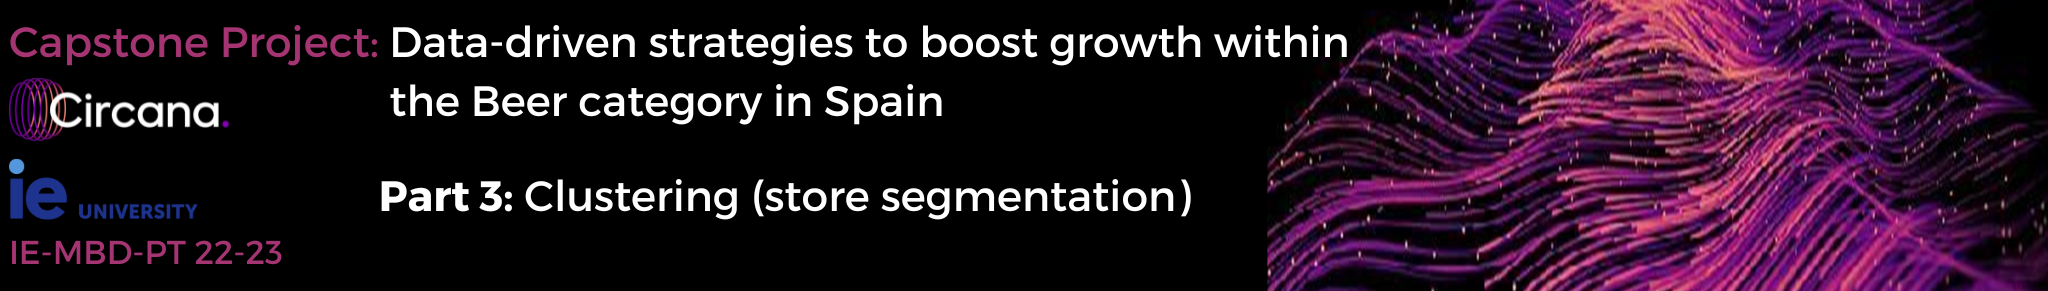

In [2]:
from IPython.display import Image
Image(filename='images/header-part3.png')

This notebook delves into the realm of store segmentation and clustering, specifically tailored to the beer market in Spain. Leveraging the wealth of data provided by Circana, we aim to propose a novel approach to classifying and segmenting stores. While the conventional method revolves around store type and size, we seek to uncover alternative dimensions and factors that can better capture the unique characteristics and behaviors of stores in this industry.

The **primary objective** of this analysis is to **present a different way of classifying and segmenting beer stores in Spain**. By utilizing the available information, we will describe and explain the potential store segmentation based on factors beyond the traditional store type and size criteria. Our approach aims to offer valuable insights that can enhance marketing strategies, optimize resource allocation, and drive business growth for beer retailers and producers.

To accomplish our objective, we will employ advanced data analytics techniques, specifically focusing on segmentation and clustering algorithms. These algorithms will allow us to identify distinct groups of stores based on a variety of variables not taking into consideration by the traditional approach. By incorporating these additional factors, we can gain a more nuanced understanding of the market and uncover hidden patterns that were previously overlooked.

## <span style="color: purple">**Table of contents**</span> <a class="anchor"></a>
- [<span style="color: purple">0. Preparing the environment</span>](#section_0)
- [<span style="color: purple">1. Exploratory Data Analysis for clustering dataset </span>](#section_1)
- [<span style="color: purple">2. Creating a stratified sample of 10% of the total dataset</span>](#section_2)
- [<span style="color: purple">3. Feature Handling over the Stratified Sample</span>](#section_3)
  - [<span style="color: purple">3.1. Handling Highly Correlated Features</span>](#section_3_1)
  - [<span style="color: purple">3.2. Irrelevant Features Handling</span>](#section_3_2)
  - [<span style="color: purple">3.3. Selection of Clustering Vs.Profiling Features</span>](#section_3_3)
  - [<span style="color: purple">3.4. Handling of Categorical Features</span>](#section_3_4)
  - [<span style="color: purple">3.5. Standardization and Scaling of Numerical Features </span>](#section_3_5)
  - [<span style="color: purple">3.6. Feature Importance</span>](#section_3_6)
- [<span style="color: purple">4. Clustering and Segmentation </span>](#section_4)
  - [<span style="color: purple">4.1. Mini-Batch Kmeans</span>](#section_4_1)
  - [<span style="color: purple">4.2. Visualization of Clusters</span>](#section_4_2)
- [<span style="color: purple">5.Conclusion & Recommendation</span>](#section_5)
  
  


## <span style="color: purple">**0. Preparing the environment**</span> <a class="anchor" id="section_0"></a>

In [6]:
#Importing the libraries
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import datetime
import numpy as np
import seaborn as sns
%matplotlib inline
from graphviz import Source



import warnings
warnings.filterwarnings("ignore")

In [7]:
file_path=('datasets/circana_data.csv')

In [8]:
#We are loading the data into chunks to nsure the full datastet is used

#Read the file in chunks
chunk_size = 100000  # Adjust the chunk size as per your needs
df_chunks = pd.read_csv(file_path, chunksize=chunk_size)

#Initialize an empty list to store the chunks
all_chunks = []

#Process each chunk and append it to the list
for chunk in df_chunks:
    all_chunks.append(chunk)

#Concatenate all the chunks into one big DataFrame
big_dataframe = pd.concat(all_chunks, ignore_index=True)

In [9]:
circana_df_1 = big_dataframe.copy()

# <span style="color: purple">**1. Exploratory Data Analysis for clustering dataset**</span> <a class="anchor" id="section_1"></a>


In this section, we will take a closer look at the clustering dataset. We will perform an initial exploratory data analysis to gain a better understanding of the data and its characteristics. This will allow us to identify potential issues and challenges that we will need to address in the next section.

Here, our objective is not covering a complete EDA, which has already been performed in part 1, but rather to get a general idea of the data and its features, and the overall structure of the dataset, to anticipate problems when applying clustering algorithms.

In [10]:
circana_df_1.head()

Store Code  Week Code  Product Code  Sales in units  Sales in value (€)  \
0         243         42           236              30               19.50   
1         243        108           236              17               11.05   
2         243         68           236               9                4.95   
3         243         11           236              33               15.84   
4         243         49           236               3                1.95   

   Sales in volume (Lt)  Number of references  Real price in units  \
0                    10                     1                 0.65   
1                     6                     1                 0.65   
2                     3                     1                 0.55   
3                    11                     1                 0.48   
4                     1                     1                 0.65   

   Real price in volume  Rate price in units  ...  VOLUME  UNITS  min temp  \
0                  0.33                 0.65  ...     330      1  5.671429   
1                  0.33                 0.65  ...     330      1  2.971429   
2                  0.33                 0.55  ...     330      1  9.600000   
3                  0.33                 0.65  ...     330      1  4.142857   
4                  0.33                 0.65  ...     330      1 -0.042857   

    max temp  mean temp  precipitation        promotion  holiday  population  \
0  12.285714   8.800000       1.285714             None      0.0      241713   
1  10.471429   6.671429       1.800000             None      0.0      241713   
2  21.542857  15.500000       1.771429             None      2.0      241713   
3  12.442857   8.114286       2.785714  Promo descuento      2.0      241713   
4   6.842857   2.600000       0.071429             None      2.0      241713   

  liters/person  
0      0.000041  
1      0.000025  
2      0.000012  
3      0.000046  
4      0.000004  

[5 rows x 36 columns]

In [11]:
circana_df_1['SEGMENT'].unique()

array(['EXTRA', 'IMPORT SPECIAL', 'IMPORT PREMIUM', 'NATIONAL', 'BLACK',
       'FLAVOURED', 'WITHOUT ALCOHOL', 'ZERO ALCOHOL', 'CELIACS',
       'ARTISANS'], dtype=object)

In [12]:
circana_df_1['UNITS'].unique()

array([ 1,  6, 12,  8, 10, 24,  4,  5,  9,  3, 28, 18,  2, 20, 16],
      dtype=int64)

In [13]:
circana_df_1['PACKAGING'].unique()

array(['CAN', 'CRISTAL BOTTLE', 'PET', 'OTHER'], dtype=object)

In [14]:
circana_df_1.dtypes

Store Code                  int64
Week Code                   int64
Product Code                int64
Sales in units              int64
Sales in value (€)        float64
Sales in volume (Lt)        int64
Number of references        int64
Real price in units       float64
Real price in volume      float64
Rate price in units       float64
Rate price in volume      float64
Month                       int64
Year                        int64
Season                     object
Quarter                     int64
channel_code                int64
province code               int64
postal_code                 int64
sales_surface_sqmeters      int64
Province                   object
Autonomus Community        object
Channel                    object
SEGMENT                    object
MANUFACTURER               object
BRAND                      object
PACKAGING                  object
VOLUME                      int64
UNITS                       int64
min temp                  float64
max temp      

In [15]:
circana_df_1.shape

(5547705, 36)

In [16]:
circana_df_1.isna().sum()

Store Code                0
Week Code                 0
Product Code              0
Sales in units            0
Sales in value (€)        0
Sales in volume (Lt)      0
Number of references      0
Real price in units       0
Real price in volume      0
Rate price in units       0
Rate price in volume      0
Month                     0
Year                      0
Season                    0
Quarter                   0
channel_code              0
province code             0
postal_code               0
sales_surface_sqmeters    0
Province                  0
Autonomus Community       0
Channel                   0
SEGMENT                   0
MANUFACTURER              0
BRAND                     0
PACKAGING                 0
VOLUME                    0
UNITS                     0
min temp                  0
max temp                  0
mean temp                 0
precipitation             0
promotion                 0
holiday                   0
population                0
liters/person       

In [17]:
column_names_list = circana_df_1.columns.tolist()

In [18]:
column_names_list

['Store Code',
 'Week Code',
 'Product Code',
 'Sales in units',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Number of references',
 'Real price in units',
 'Real price in volume',
 'Rate price in units',
 'Rate price in volume',
 'Month',
 'Year',
 'Season',
 'Quarter',
 'channel_code',
 'province code',
 'postal_code',
 'sales_surface_sqmeters',
 'Province',
 'Autonomus Community',
 'Channel',
 'SEGMENT',
 'MANUFACTURER',
 'BRAND',
 'PACKAGING',
 'VOLUME',
 'UNITS',
 'min temp',
 'max temp',
 'mean temp',
 'precipitation',
 'promotion',
 'holiday',
 'population',
 'liters/person']

In [19]:
#Saving a Copy from the df to start the transformations and needed changes prior to clustering
circana_df_1copy = circana_df_1.copy()

# <span style="color: purple">**2. Creating a stratified sample of 10% of the total dataset**</span> <a class="anchor" id="section_2"></a>

- Since the df is quite large of +5.5M rows, strategically we will extract a stratified sample of 500K rows (~10% of the df size) to work with
- We set our target variable be **Store Code** to ensure all stores are well represented in this sample

In [20]:
#Set the target variable for stratification
target_variable = 'Store Code'  # Replace with the actual target variable column name

#Check the class distribution
class_counts = circana_df_1copy[target_variable].value_counts()
single_member_classes = class_counts[class_counts == 1].index.tolist()

#Remove classes with only one member
circana_df_1_filtered = circana_df_1copy[~circana_df_1copy[target_variable].isin(single_member_classes)]

#Perform stratified sampling
train_data, sample_data = train_test_split(circana_df_1_filtered, train_size=500000, stratify=circana_df_1_filtered[target_variable])

#The 'train_data' variable will contain the stratified sample of 500,000 rows


In [21]:
train_data.shape

(500000, 36)

In [22]:
# Creating a copy of the sample df to save prior to changes
circana_train_data = train_data.copy()

# <span style="color: purple">**3. Feature Handling over the Stratified Sample**</span> <a class="anchor" id="section_3"></a>

Now, let's proceed to the feature handling stage for the stratified sample, focusing on variable correlation analysis, one-hot encoding for categorical variables and elimination of irrelevant features prior to running the clustering algorithms. This process will enable us to enhance the quality and relevance of the data used for segmentation and clustering. By carefully managing the features, we can extract meaningful insights and ensure the accuracy and effectiveness of the subsequent analysis.

## <span style="color: purple">3.1. Handling Highly Correlated Features</span> <a class="anchor" id="section_3_1"></a>

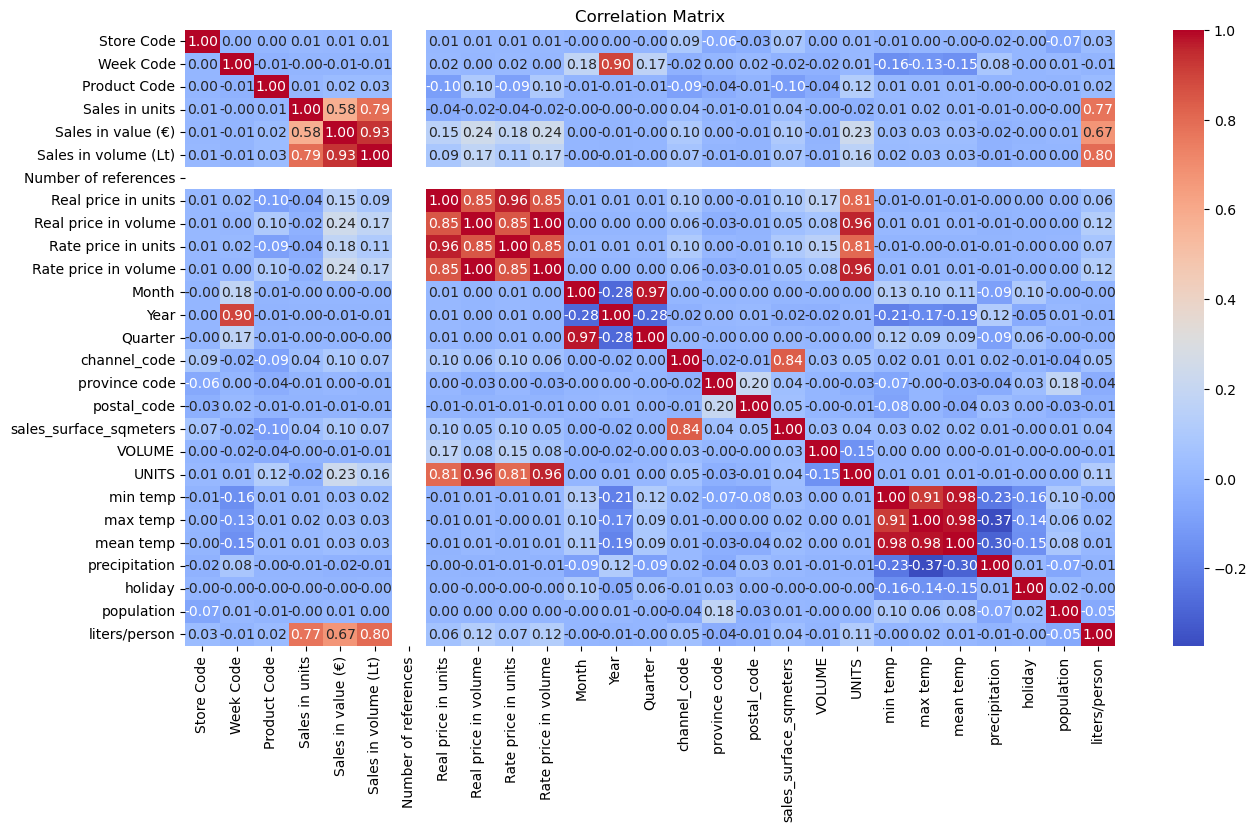

In [23]:
#We will start by plotting the correlation matrix to see the correlation between the features
#Calculate the correlation matrix
correlation_matrix_clean = circana_train_data.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix_clean, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**From the above we conclude the below:**


*   Keep 1 feature only ‘Real price in units’ instead of having'Real price in units', 'Real price in volume', 'Rate price in units', 'UNITS'
*   Keep 1 feature only ‘channel_code’ dropping 'sales_surface_sqmeters'
*   Keep 1 feature only ‘mean temp’ dropping'min temp', 'max temp'


In [24]:
#Drop highly correlated features
features_to_drop = ['Real price in volume', 'Rate price in units',
       'Rate price in volume', 'UNITS',
       'min temp', 'max temp']
circana_train_data = circana_train_data.drop(features_to_drop, axis=1)

In [25]:
#showing uodated fields after dropping highly correlated features
circana_train_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'mean temp',
       'precipitation', 'promotion', 'holiday', 'population', 'liters/person'],
      dtype='object')

In [26]:
circana_train_data.shape

(500000, 30)

In [27]:
column_names_list = circana_train_data.columns.tolist()
column_names_list

['Store Code',
 'Week Code',
 'Product Code',
 'Sales in units',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Number of references',
 'Real price in units',
 'Month',
 'Year',
 'Season',
 'Quarter',
 'channel_code',
 'province code',
 'postal_code',
 'sales_surface_sqmeters',
 'Province',
 'Autonomus Community',
 'Channel',
 'SEGMENT',
 'MANUFACTURER',
 'BRAND',
 'PACKAGING',
 'VOLUME',
 'mean temp',
 'precipitation',
 'promotion',
 'holiday',
 'population',
 'liters/person']

## <span style="color: purple">3.2. Irrelevant Features Handling </span> <a class="anchor" id="section_3_2"></a>

At this section we will drop some features that we have considered irrelevant for the clustering analysis.

In [28]:
#Dropping the non nedded columns
features_to_drop = ['Week Code', 'Product Code', 'Number of references','Month','Year','Quarter','province code','postal_code']
circana_train_data = circana_train_data.drop(features_to_drop, axis=1)

In [29]:
circana_train_data.shape

(500000, 22)

In [31]:
column_names_list = circana_train_data.columns.tolist()
column_names_list

['Store Code',
 'Sales in units',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Real price in units',
 'Season',
 'channel_code',
 'sales_surface_sqmeters',
 'Province',
 'Autonomus Community',
 'Channel',
 'SEGMENT',
 'MANUFACTURER',
 'BRAND',
 'PACKAGING',
 'VOLUME',
 'mean temp',
 'precipitation',
 'promotion',
 'holiday',
 'population',
 'liters/person']

## <span style="color: purple">3.3. Selection of Clustering Vs.Profiling Features</span> <a class="anchor" id="section_3_3"></a>

For our Store Segmentation Strategy, it is essential to create a new DataFrame that incorporates strategic features believed to significantly impact sales. By carefully selecting and incorporating these features, we aim to shape our segmentation in a way that maximizes sales potential.

For the Clustering Features, we will only keep;
1. 'Sales in value (€)',
2. 'Real price in volume',
3. 'Autonomus Community',
4. 'SEGMENT',
5. 'mean temp',
6. 'promotion',
7. 'liters/person'


While for Profiling features we will keep the following ones:
1. 'Store Code',
2. 'Sales in volume (Lt)',
3. 'channel_code',
4. 'sales_surface_sqmeters',
5. 'BRAND'
6. 'population'

In [32]:
#We drop the features that we don't want to use
features_to_drop = [
 'Sales in units',
 'Season',
 'Province',
 'Channel',
 'PACKAGING',
  'MANUFACTURER',
 'VOLUME',
 'precipitation',
 'holiday']
circana_strat_df = circana_train_data.drop(features_to_drop, axis=1)

In [33]:
circana_strat_df.shape

(500000, 13)

## <span style="color: purple">3.4. Handling of Categorical Features</span> <a class="anchor" id="section_3_4"></a>
- Hot encoding
- Treating collenearity

Encoding Categorical Values : VOLUME , SEGMENT, BRAND, PACKING , PROMOTION

In [35]:
#We select the columns to one-hot encode
columns_to_encode = ['SEGMENT', 'Autonomus Community','promotion']

#Perform one-hot encoding on the specified columns
circana_data_encoded = pd.get_dummies(circana_strat_df, columns=columns_to_encode, prefix=columns_to_encode)

print(circana_data_encoded)

         Store Code  Sales in value (€)  Sales in volume (Lt)  \
1522969           5              307.89                  3695   
5528627         336               36.25                    17   
1280406         525                6.12                     4   
4837662          19                4.30                     1   
890737           35              243.10                   195   
...             ...                 ...                   ...   
150199          474                0.69                     0   
3479753         461                1.56                     1   
2929053         507               59.36                    55   
2642422         420                3.42                     2   
5520447         155                3.30                     1   

         Real price in units  channel_code  sales_surface_sqmeters  \
1522969                 0.33             1                     900   
5528627                 7.25             2                   12300   
1280406  

In [36]:
circana_data_encoded.columns.tolist()

['Store Code',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Real price in units',
 'channel_code',
 'sales_surface_sqmeters',
 'BRAND',
 'mean temp',
 'population',
 'liters/person',
 'SEGMENT_ARTISANS',
 'SEGMENT_BLACK',
 'SEGMENT_CELIACS',
 'SEGMENT_EXTRA',
 'SEGMENT_FLAVOURED',
 'SEGMENT_IMPORT PREMIUM',
 'SEGMENT_IMPORT SPECIAL',
 'SEGMENT_NATIONAL',
 'SEGMENT_WITHOUT ALCOHOL',
 'SEGMENT_ZERO ALCOHOL',
 'Autonomus Community_Andalucía',
 'Autonomus Community_Aragón',
 'Autonomus Community_Asturias',
 'Autonomus Community_Baleares',
 'Autonomus Community_Cantabria',
 'Autonomus Community_Castilla y León',
 'Autonomus Community_Castilla-La Mancha',
 'Autonomus Community_Cataluña',
 'Autonomus Community_Comunidad Valenciana',
 'Autonomus Community_Extremadura',
 'Autonomus Community_Galicia',
 'Autonomus Community_La Rioja',
 'Autonomus Community_Madrid',
 'Autonomus Community_Murcia',
 'Autonomus Community_Navarra',
 'Autonomus Community_País Vasco',
 'promotion_None',
 'promotio

In [37]:
circana_data_encoded.shape

(500000, 45)

In [38]:
circana_data_encoded_copy = circana_data_encoded.copy()

In [39]:
#From the hot encoded categories, we drop one feature of each to avoid collenearity 
features_to_drop = ['SEGMENT_ZERO ALCOHOL', 'Autonomus Community_Aragón', 'promotion_Promo isla']
circana_data_encoded_copy = circana_data_encoded_copy.drop(features_to_drop, axis=1)

In [40]:
circana_data_encoded_copy.shape

(500000, 42)

In [41]:
column_names_list = circana_data_encoded_copy.columns.tolist()
column_names_list

['Store Code',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Real price in units',
 'channel_code',
 'sales_surface_sqmeters',
 'BRAND',
 'mean temp',
 'population',
 'liters/person',
 'SEGMENT_ARTISANS',
 'SEGMENT_BLACK',
 'SEGMENT_CELIACS',
 'SEGMENT_EXTRA',
 'SEGMENT_FLAVOURED',
 'SEGMENT_IMPORT PREMIUM',
 'SEGMENT_IMPORT SPECIAL',
 'SEGMENT_NATIONAL',
 'SEGMENT_WITHOUT ALCOHOL',
 'Autonomus Community_Andalucía',
 'Autonomus Community_Asturias',
 'Autonomus Community_Baleares',
 'Autonomus Community_Cantabria',
 'Autonomus Community_Castilla y León',
 'Autonomus Community_Castilla-La Mancha',
 'Autonomus Community_Cataluña',
 'Autonomus Community_Comunidad Valenciana',
 'Autonomus Community_Extremadura',
 'Autonomus Community_Galicia',
 'Autonomus Community_La Rioja',
 'Autonomus Community_Madrid',
 'Autonomus Community_Murcia',
 'Autonomus Community_Navarra',
 'Autonomus Community_País Vasco',
 'promotion_None',
 'promotion_Promo cabecera',
 'promotion_Promo descuento',
 'promo

Now, we will check again the correlation matrix.

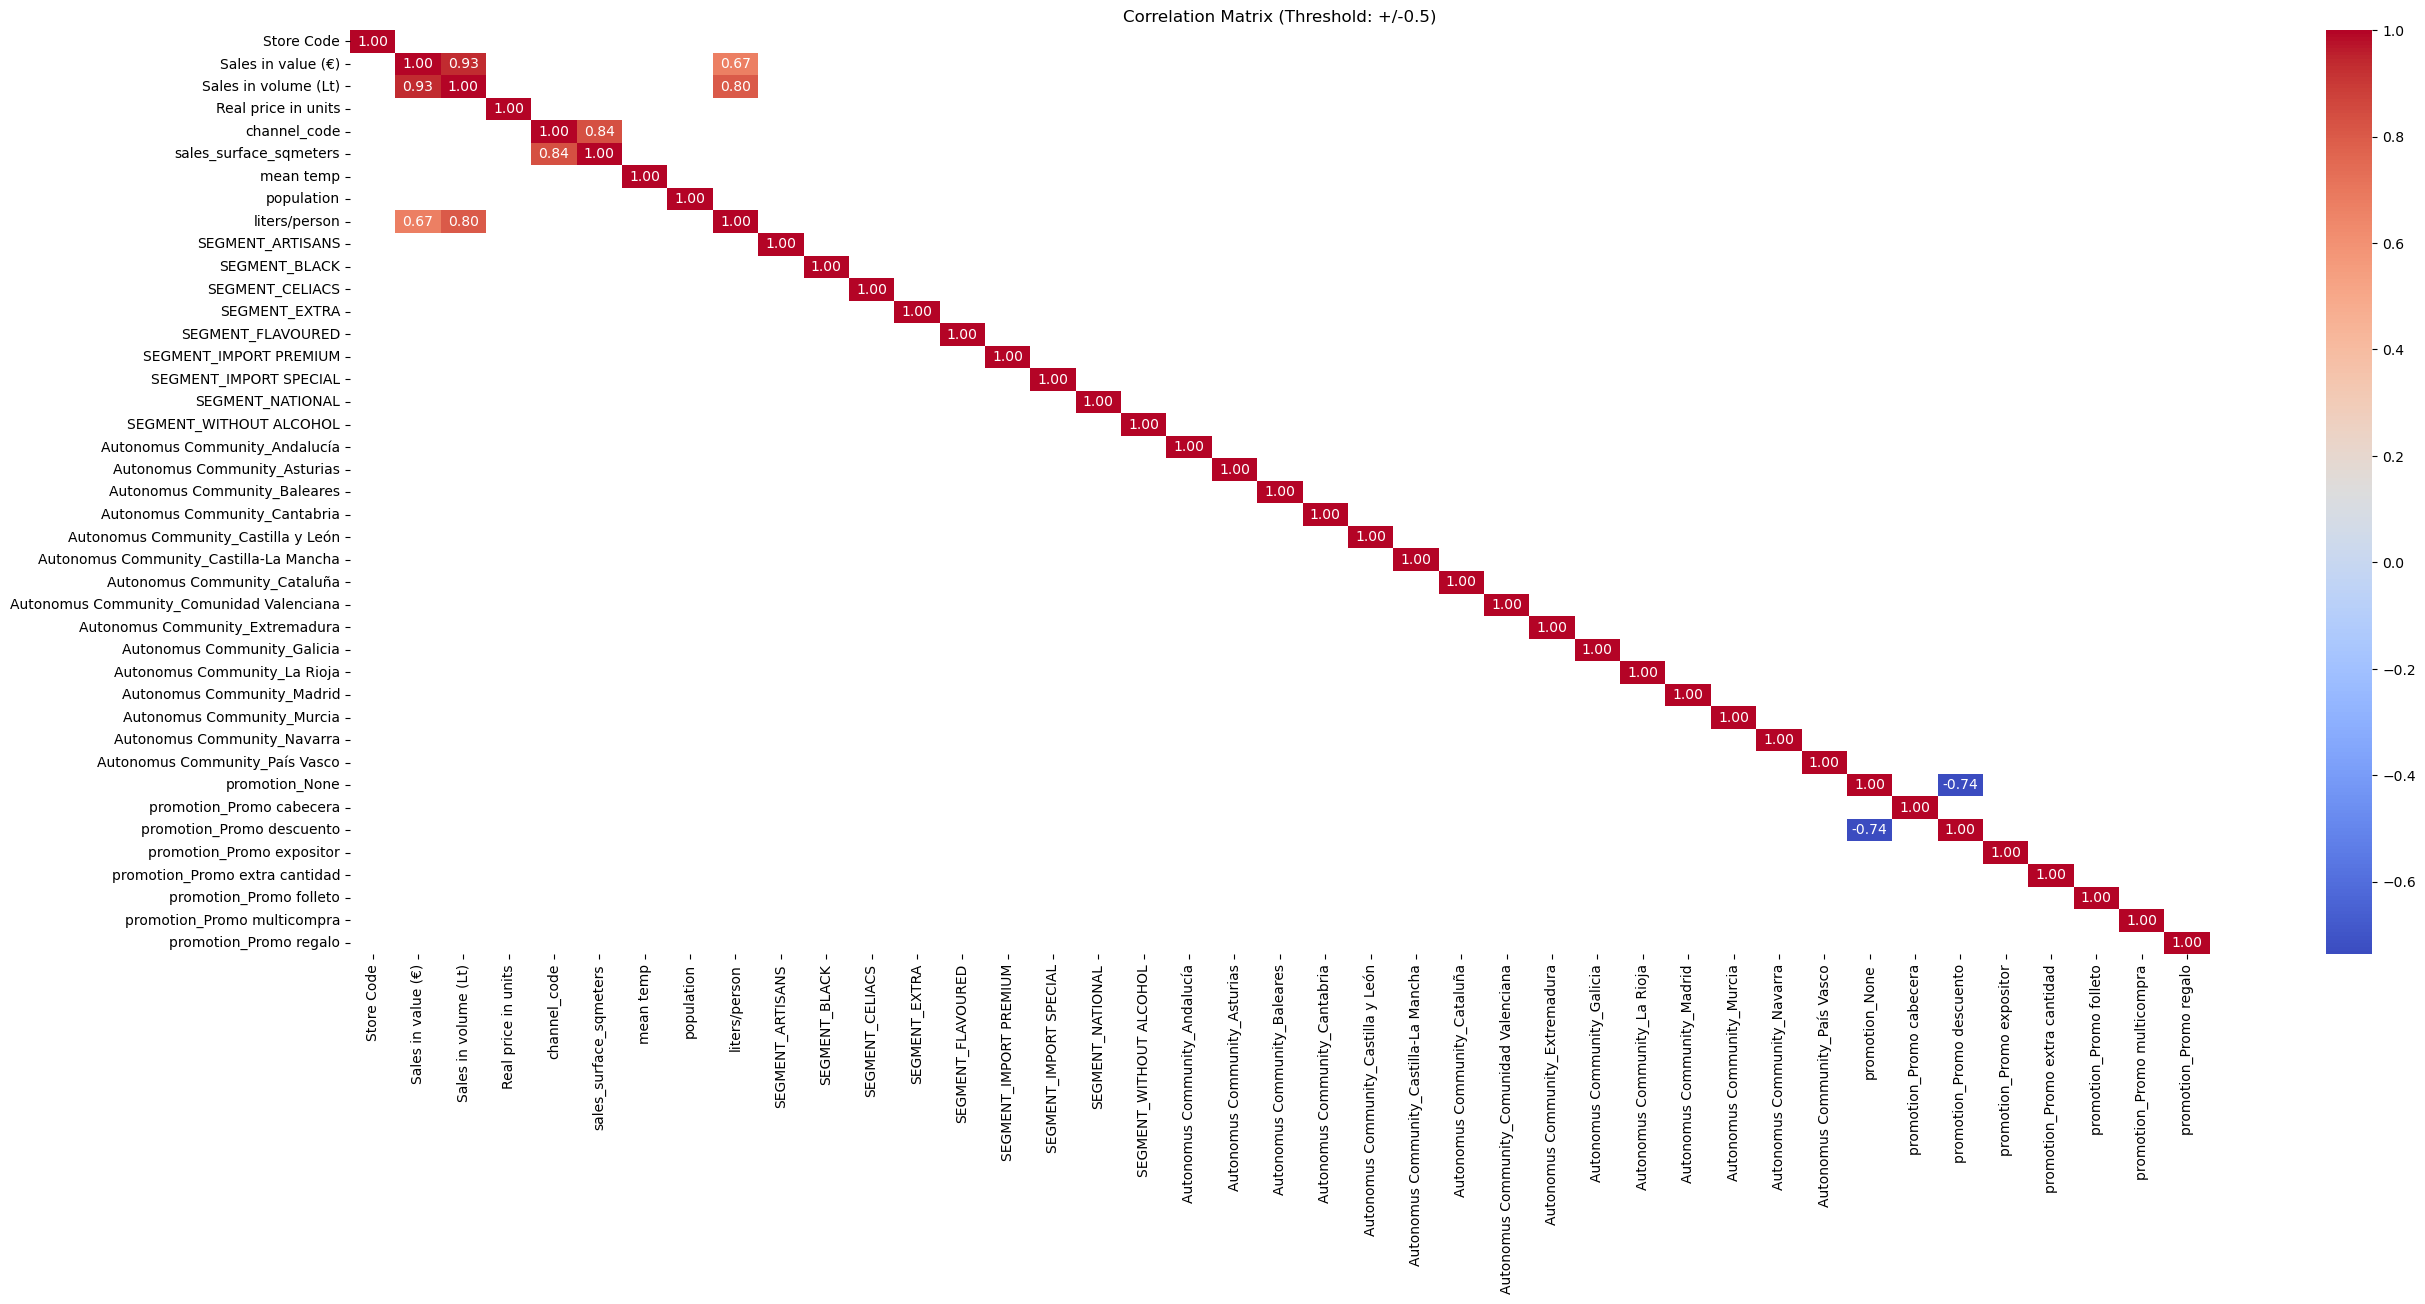

In [42]:
correlation_matrix = circana_data_encoded_copy.corr()

#We apply a threshold to the correlation matrix to see the features that are highly correlated
correlation_matrix_thresholded = correlation_matrix.where((correlation_matrix > 0.5) | (correlation_matrix < -0.5))

plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix_thresholded, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Threshold: +/-0.5)')
plt.show()


In [43]:
#Drop multiple features based on the above matrix of +/-0.5 threshhold
features_to_drop = ['promotion_Promo descuento']
circana_data_encoded_copy = circana_data_encoded_copy.drop(features_to_drop, axis=1)

## <span style="color: purple">3.5. Standardization and Scaling of Numerical Features </span> <a class="anchor" id="section_3_4"></a>

To avoid the effect of different scales, we will standardize the numerical features.

In [44]:
circana_data_encoded_copy.head(1)

Store Code  Sales in value (€)  Sales in volume (Lt)  \
1522969           5              307.89                  3695   

         Real price in units  channel_code  sales_surface_sqmeters  \
1522969                 0.33             1                     900   

                   BRAND  mean temp  population  liters/person  ...  \
1522969  MAN 3 - BRAND 4  11.657143      443161       0.008338  ...   

         Autonomus Community_Murcia  Autonomus Community_Navarra  \
1522969                           0                            0   

         Autonomus Community_País Vasco  promotion_None  \
1522969                               0               0   

         promotion_Promo cabecera  promotion_Promo expositor  \
1522969                         0                          0   

         promotion_Promo extra cantidad  promotion_Promo folleto  \
1522969                               0                        0   

         promotion_Promo multicompra  promotion_Promo regalo  
1522969                            0                       0  

[1 rows x 41 columns]

In [46]:
circana_data_encoded_copy.columns.tolist()

['Store Code',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Real price in units',
 'channel_code',
 'sales_surface_sqmeters',
 'BRAND',
 'mean temp',
 'population',
 'liters/person',
 'SEGMENT_ARTISANS',
 'SEGMENT_BLACK',
 'SEGMENT_CELIACS',
 'SEGMENT_EXTRA',
 'SEGMENT_FLAVOURED',
 'SEGMENT_IMPORT PREMIUM',
 'SEGMENT_IMPORT SPECIAL',
 'SEGMENT_NATIONAL',
 'SEGMENT_WITHOUT ALCOHOL',
 'Autonomus Community_Andalucía',
 'Autonomus Community_Asturias',
 'Autonomus Community_Baleares',
 'Autonomus Community_Cantabria',
 'Autonomus Community_Castilla y León',
 'Autonomus Community_Castilla-La Mancha',
 'Autonomus Community_Cataluña',
 'Autonomus Community_Comunidad Valenciana',
 'Autonomus Community_Extremadura',
 'Autonomus Community_Galicia',
 'Autonomus Community_La Rioja',
 'Autonomus Community_Madrid',
 'Autonomus Community_Murcia',
 'Autonomus Community_Navarra',
 'Autonomus Community_País Vasco',
 'promotion_None',
 'promotion_Promo cabecera',
 'promotion_Promo expositor',
 'promo

In [47]:
#We start by creating a copy of the df to save prior to changes
circana_data_scaled = circana_data_encoded_copy.copy()

#We identify the features to scale
features_to_scale = ['Sales in volume (Lt)','channel_code', 'liters/person','Sales in value (€)','Real price in units','sales_surface_sqmeters', 'mean temp',  'sales_surface_sqmeters','population']  # Replace with your actual feature names

scaler = StandardScaler()s
circana_data_scaled[features_to_scale] = scaler.fit_transform(circana_data_scaled[features_to_scale])


print(circana_data_scaled)

         Store Code  Sales in value (€)  Sales in volume (Lt)  \
3948282         380           -0.095907             -0.070060   
2281377         228           -0.169255             -0.120848   
1497533         380            0.239426              0.095672   
2878681         144           -0.189348             -0.131541   
4944637         259           -0.173059             -0.120848   
...             ...                 ...                   ...   
2759            422           -0.180959             -0.128868   
4372126         280           -0.184503             -0.131541   
3546648         155           -0.174587             -0.131541   
2907224         124           -0.169190             -0.126195   
3969304         485           -0.178293             -0.120848   

         Real price in units  channel_code  sales_surface_sqmeters  \
3948282            -0.716709      0.990687                1.336590   
2281377            -0.692157      0.990687                1.694831   
1497533  

In [48]:
#Checking the df head to ensure scale and standardization
circana_data_scaled.head(2)

Store Code  Sales in value (€)  Sales in volume (Lt)  \
3948282         380           -0.095907             -0.070060   
2281377         228           -0.169255             -0.120848   

         Real price in units  channel_code  sales_surface_sqmeters  \
3948282            -0.716709      0.990687                1.336590   
2281377            -0.692157      0.990687                1.694831   

                        BRAND  mean temp  population  liters/person  ...  \
3948282       MAN 1 - BRAND 1   0.439001   -0.834148      -0.018897  ...   
2281377  MAN 2 - OTHER BRANDS  -0.660720    0.428559      -0.091200  ...   

         Autonomus Community_Murcia  Autonomus Community_Navarra  \
3948282                           0                            0   
2281377                           0                            0   

         Autonomus Community_País Vasco  promotion_None  \
3948282                               0               1   
2281377                               0               1   

         promotion_Promo cabecera  promotion_Promo expositor  \
3948282                         0                          0   
2281377                         0                          0   

         promotion_Promo extra cantidad  promotion_Promo folleto  \
3948282                               0                        0   
2281377                               0                        0   

         promotion_Promo multicompra  promotion_Promo regalo  
3948282                            0                       0  
2281377                            0                       0  

[2 rows x 41 columns]

## <span style="color: purple">3.6.Feature Importance </span> <a class="anchor" id="section_3_4"></a>

At this point, we will use the feature importance table previously found in Part 2 to identify the most important features for our clustering analysis.


**Market Drivers Findings (based on XGBOOST Analysis Conducted for the Market Drivers Business Topic)**

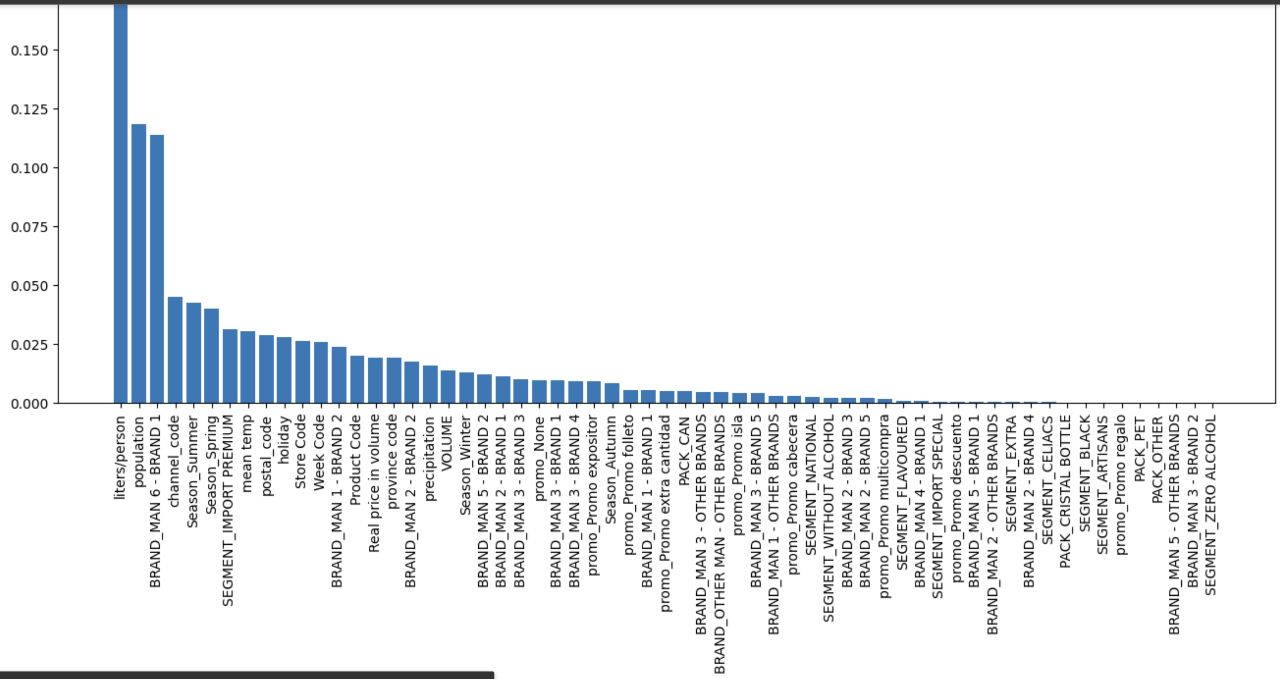

# <span style="color: purple">**4. Clustering and Segmentation**</span> <a class="anchor" id="section_4"></a>

In our initial exploration we ran the clustering using multiple algorthims such as K- means, DBScan and Agglomertative clustering. However, due to the size of the data we selected the K-Means Mini Batch clustering as it was fit for the data size and the intial results were more fit into explanation as well as alignment with remaining capstone indicators

Nevertheless, it is evident that we can do subclustering using different algorithms as future improvement based on the results recieved

## <span style="color: purple">4.1. Mini-Batch Kmeans</span> <a class="anchor" id="section_4_1"></a>

- Below, we conduct a final df check for shape and type and size prior to clusterization.
- Model selected for our exercise is the Mini Batch K-Means which fits our segementation objective while accommodating for the nature of our relatively large dataframe.

In [49]:
circana_data_scaled.columns.tolist()

['Store Code',
 'Sales in value (€)',
 'Sales in volume (Lt)',
 'Real price in units',
 'channel_code',
 'sales_surface_sqmeters',
 'BRAND',
 'mean temp',
 'population',
 'liters/person',
 'SEGMENT_ARTISANS',
 'SEGMENT_BLACK',
 'SEGMENT_CELIACS',
 'SEGMENT_EXTRA',
 'SEGMENT_FLAVOURED',
 'SEGMENT_IMPORT PREMIUM',
 'SEGMENT_IMPORT SPECIAL',
 'SEGMENT_NATIONAL',
 'SEGMENT_WITHOUT ALCOHOL',
 'Autonomus Community_Andalucía',
 'Autonomus Community_Asturias',
 'Autonomus Community_Baleares',
 'Autonomus Community_Cantabria',
 'Autonomus Community_Castilla y León',
 'Autonomus Community_Castilla-La Mancha',
 'Autonomus Community_Cataluña',
 'Autonomus Community_Comunidad Valenciana',
 'Autonomus Community_Extremadura',
 'Autonomus Community_Galicia',
 'Autonomus Community_La Rioja',
 'Autonomus Community_Madrid',
 'Autonomus Community_Murcia',
 'Autonomus Community_Navarra',
 'Autonomus Community_País Vasco',
 'promotion_None',
 'promotion_Promo cabecera',
 'promotion_Promo expositor',
 'promo

In [50]:
circana_data_scaled.shape

(500000, 41)

In [51]:
circana_data_scaled.dtypes

Store Code                                    int64
Sales in value (€)                          float64
Sales in volume (Lt)                        float64
Real price in units                         float64
channel_code                                float64
sales_surface_sqmeters                      float64
BRAND                                        object
mean temp                                   float64
population                                  float64
liters/person                               float64
SEGMENT_ARTISANS                              uint8
SEGMENT_BLACK                                 uint8
SEGMENT_CELIACS                               uint8
SEGMENT_EXTRA                                 uint8
SEGMENT_FLAVOURED                             uint8
SEGMENT_IMPORT PREMIUM                        uint8
SEGMENT_IMPORT SPECIAL                        uint8
SEGMENT_NATIONAL                              uint8
SEGMENT_WITHOUT ALCOHOL                       uint8
Autonomus Co

## <span style="color: purple">4.2. Visualization of Clusters </span> <a class="anchor" id="section_4_2"></a>

In [52]:
#Select the clustering features that we will use
clustering_features = ['Real price in units', 'mean temp', 'Sales in value (€)',
                        'SEGMENT_IMPORT PREMIUM','sales_surface_sqmeters',
                       'SEGMENT_IMPORT SPECIAL', 'SEGMENT_NATIONAL', 'Autonomus Community_Andalucía',
                       'Autonomus Community_Asturias', 'Autonomus Community_Baleares',
                       'Autonomus Community_Cantabria', 'Autonomus Community_Castilla y León',
                       'Autonomus Community_Castilla-La Mancha', 'Autonomus Community_Cataluña',
                       'Autonomus Community_Comunidad Valenciana', 'Autonomus Community_Extremadura',
                       'Autonomus Community_Galicia', 'Autonomus Community_La Rioja',
                       'Autonomus Community_Madrid', 'Autonomus Community_Murcia',
                       'Autonomus Community_Navarra', 'Autonomus Community_País Vasco', 'promotion_None']

#Extract the clustering feature data
clustering_data = circana_data_scaled[clustering_features].values

#Normalize the clustering data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

#Set the number of clusters
k = 5

#Initialize the mini-batch k-means model
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000)

#Perform clustering
kmeans.fit(scaled_data)

#Get the cluster labels for each data point
labels = kmeans.labels_

#Add the cluster labels to the DataFrame
circana_data_scaled['Cluster'] = labels

print(circana_data_scaled['Cluster'].value_counts())

1    306473
3     93925
2     53333
4     32658
0     13611
Name: Cluster, dtype: int64


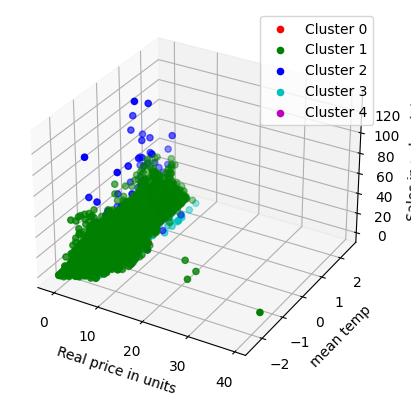

In [53]:
#Visualize the clusters in a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#Assign colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm']

for cluster_label, color in zip(range(k), colors):
    #Filter data points for the current cluster
    cluster_data = circana_data_scaled[circana_data_scaled['Cluster'] == cluster_label]

    #Plot the data points with the assigned color
    ax.scatter(cluster_data[clustering_features[0]], cluster_data[clustering_features[1]], cluster_data[clustering_features[2]], c=color, label=f'Cluster {cluster_label}')

#Set labels and legend
ax.set_xlabel(clustering_features[0])
ax.set_ylabel(clustering_features[1])
ax.set_zlabel(clustering_features[2])
ax.legend()

plt.show()

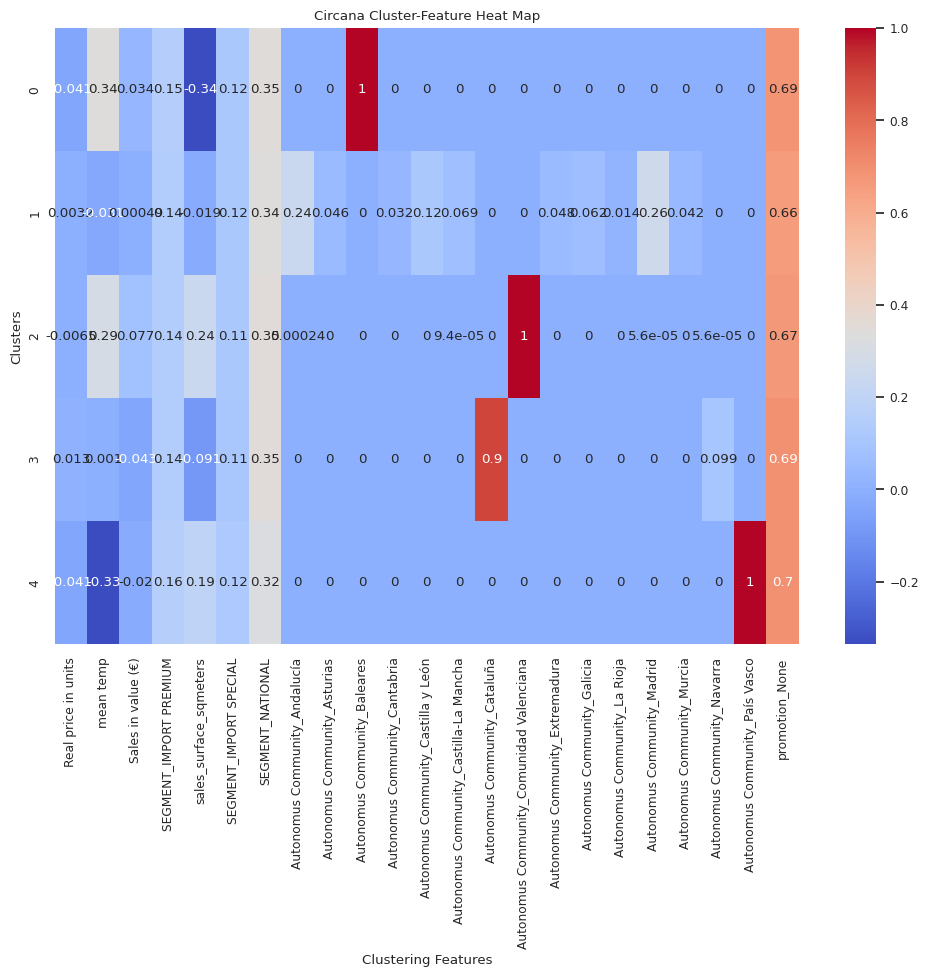

In [54]:
#We group the data by cluster and calculate the mean of each clustering feature
cluster_means = circana_data_scaled.groupby('Cluster')[clustering_features].mean()

plt.figure(figsize=(12, 8))
sns.set(font_scale=0.8)
sns.heatmap(cluster_means, cmap="coolwarm", annot=True, cbar=True)
plt.xlabel("Clustering Features")
plt.ylabel("Clusters")
plt.title("Circana Cluster-Feature Heat Map")
plt.show()


In [55]:
#Save the heat map to a file
heatmap_filename = "/content/sample_data/heatmap.png"
plt.savefig(heatmap_filename, bbox_inches='tight')
plt.close()  # Close the plot to release resources

print("Heatmap saved successfully.")

Heatmap saved successfully.


In [56]:
#Set the desired file path and name for the CSV
circana_clusters_csv = 'data_checkpoints/cluster_data.csv'

#Save the DataFrame with cluster labels as a CSV file
circana_data_scaled.to_csv(circana_clusters_csv, index=False)


In [45]:
# #Set the file path and name for the CSV
input_file = 'data_checkpoints/cluster_data.csv'

In [58]:
clusters_df = pd.read_csv(input_file)
clusters_df.head()

Store Code  Sales in value (€)  Sales in volume (Lt)  Real price in units  \
0         380           -0.095907             -0.070060            -0.716709   
1         228           -0.169255             -0.120848            -0.692157   
2         380            0.239426              0.095672             0.068935   
3         144           -0.189348             -0.131541            -0.274784   
4         259           -0.173059             -0.120848            -0.508022   

   channel_code  sales_surface_sqmeters                     BRAND  mean temp  \
0      0.990687                1.336590           MAN 1 - BRAND 1   0.439001   
1      0.990687                1.694831      MAN 2 - OTHER BRANDS  -0.660720   
2      0.990687                1.336590           MAN 3 - BRAND 4   0.942513   
3     -1.009400               -0.581053  OTHER MAN - OTHER BRANDS  -0.249905   
4      0.990687                0.704400           MAN 2 - BRAND 2  -0.344708   

   population  liters/person  ...  Autonomus Community_Navarra  \
0   -0.834148      -0.018897  ...                            0   
1    0.428559      -0.091200  ...                            0   
2   -0.834148       0.179225  ...                            0   
3   -0.273780      -0.094118  ...                            0   
4   -0.823580      -0.079957  ...                            0   

   Autonomus Community_País Vasco  promotion_None  promotion_Promo cabecera  \
0                               0               1                         0   
1                               0               1                         0   
2                               0               0                         0   
3                               0               1                         0   
4                               0               1                         0   

   promotion_Promo expositor  promotion_Promo extra cantidad  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

   promotion_Promo folleto  promotion_Promo multicompra  \
0                        0                            0   
1                        0                            0   
2                        0                            0   
3                        0                            0   
4                        0                            0   

   promotion_Promo regalo  Cluster  
0                       0        1  
1                       0        1  
2                       0        1  
3                       0        1  
4                       0        1  

[5 rows x 42 columns]

In [3]:
#Group the DataFrame by the 'Cluster' feature
clusters_grouped_df = clusters_df.groupby('Cluster')

#Iterate over the groups and extract the store codes
for cluster, group in clusters_grouped_df:
    store_codes = group['Store Code'].tolist()
    # print(f"Cluster {cluster}: {store_codes}")

In [60]:
#Group the DataFrame by the 'Cluster' feature
clusters_grouped_df = clusters_df.groupby('Cluster')

#Create a new DataFrame to store the cluster, unique store code count
cluster_unique_count_df = pd.DataFrame(columns=['Cluster', 'Unique Store Code Count'])

#Iterate over the groups and calculate the count of unique store codes
for cluster, group in clusters_grouped_df:
    unique_count = group['Store Code'].nunique()
    cluster_unique_count_df = cluster_unique_count_df.append({'Cluster': cluster, 'Unique Store Code Count': unique_count}, ignore_index=True)

#Display the cluster and unique store code count in a table
print(cluster_unique_count_df)


  Cluster Unique Store Code Count
0       0                      11
1       1                     349
2       2                      52
3       3                      91
4       4                      22


Clusters Map by Location
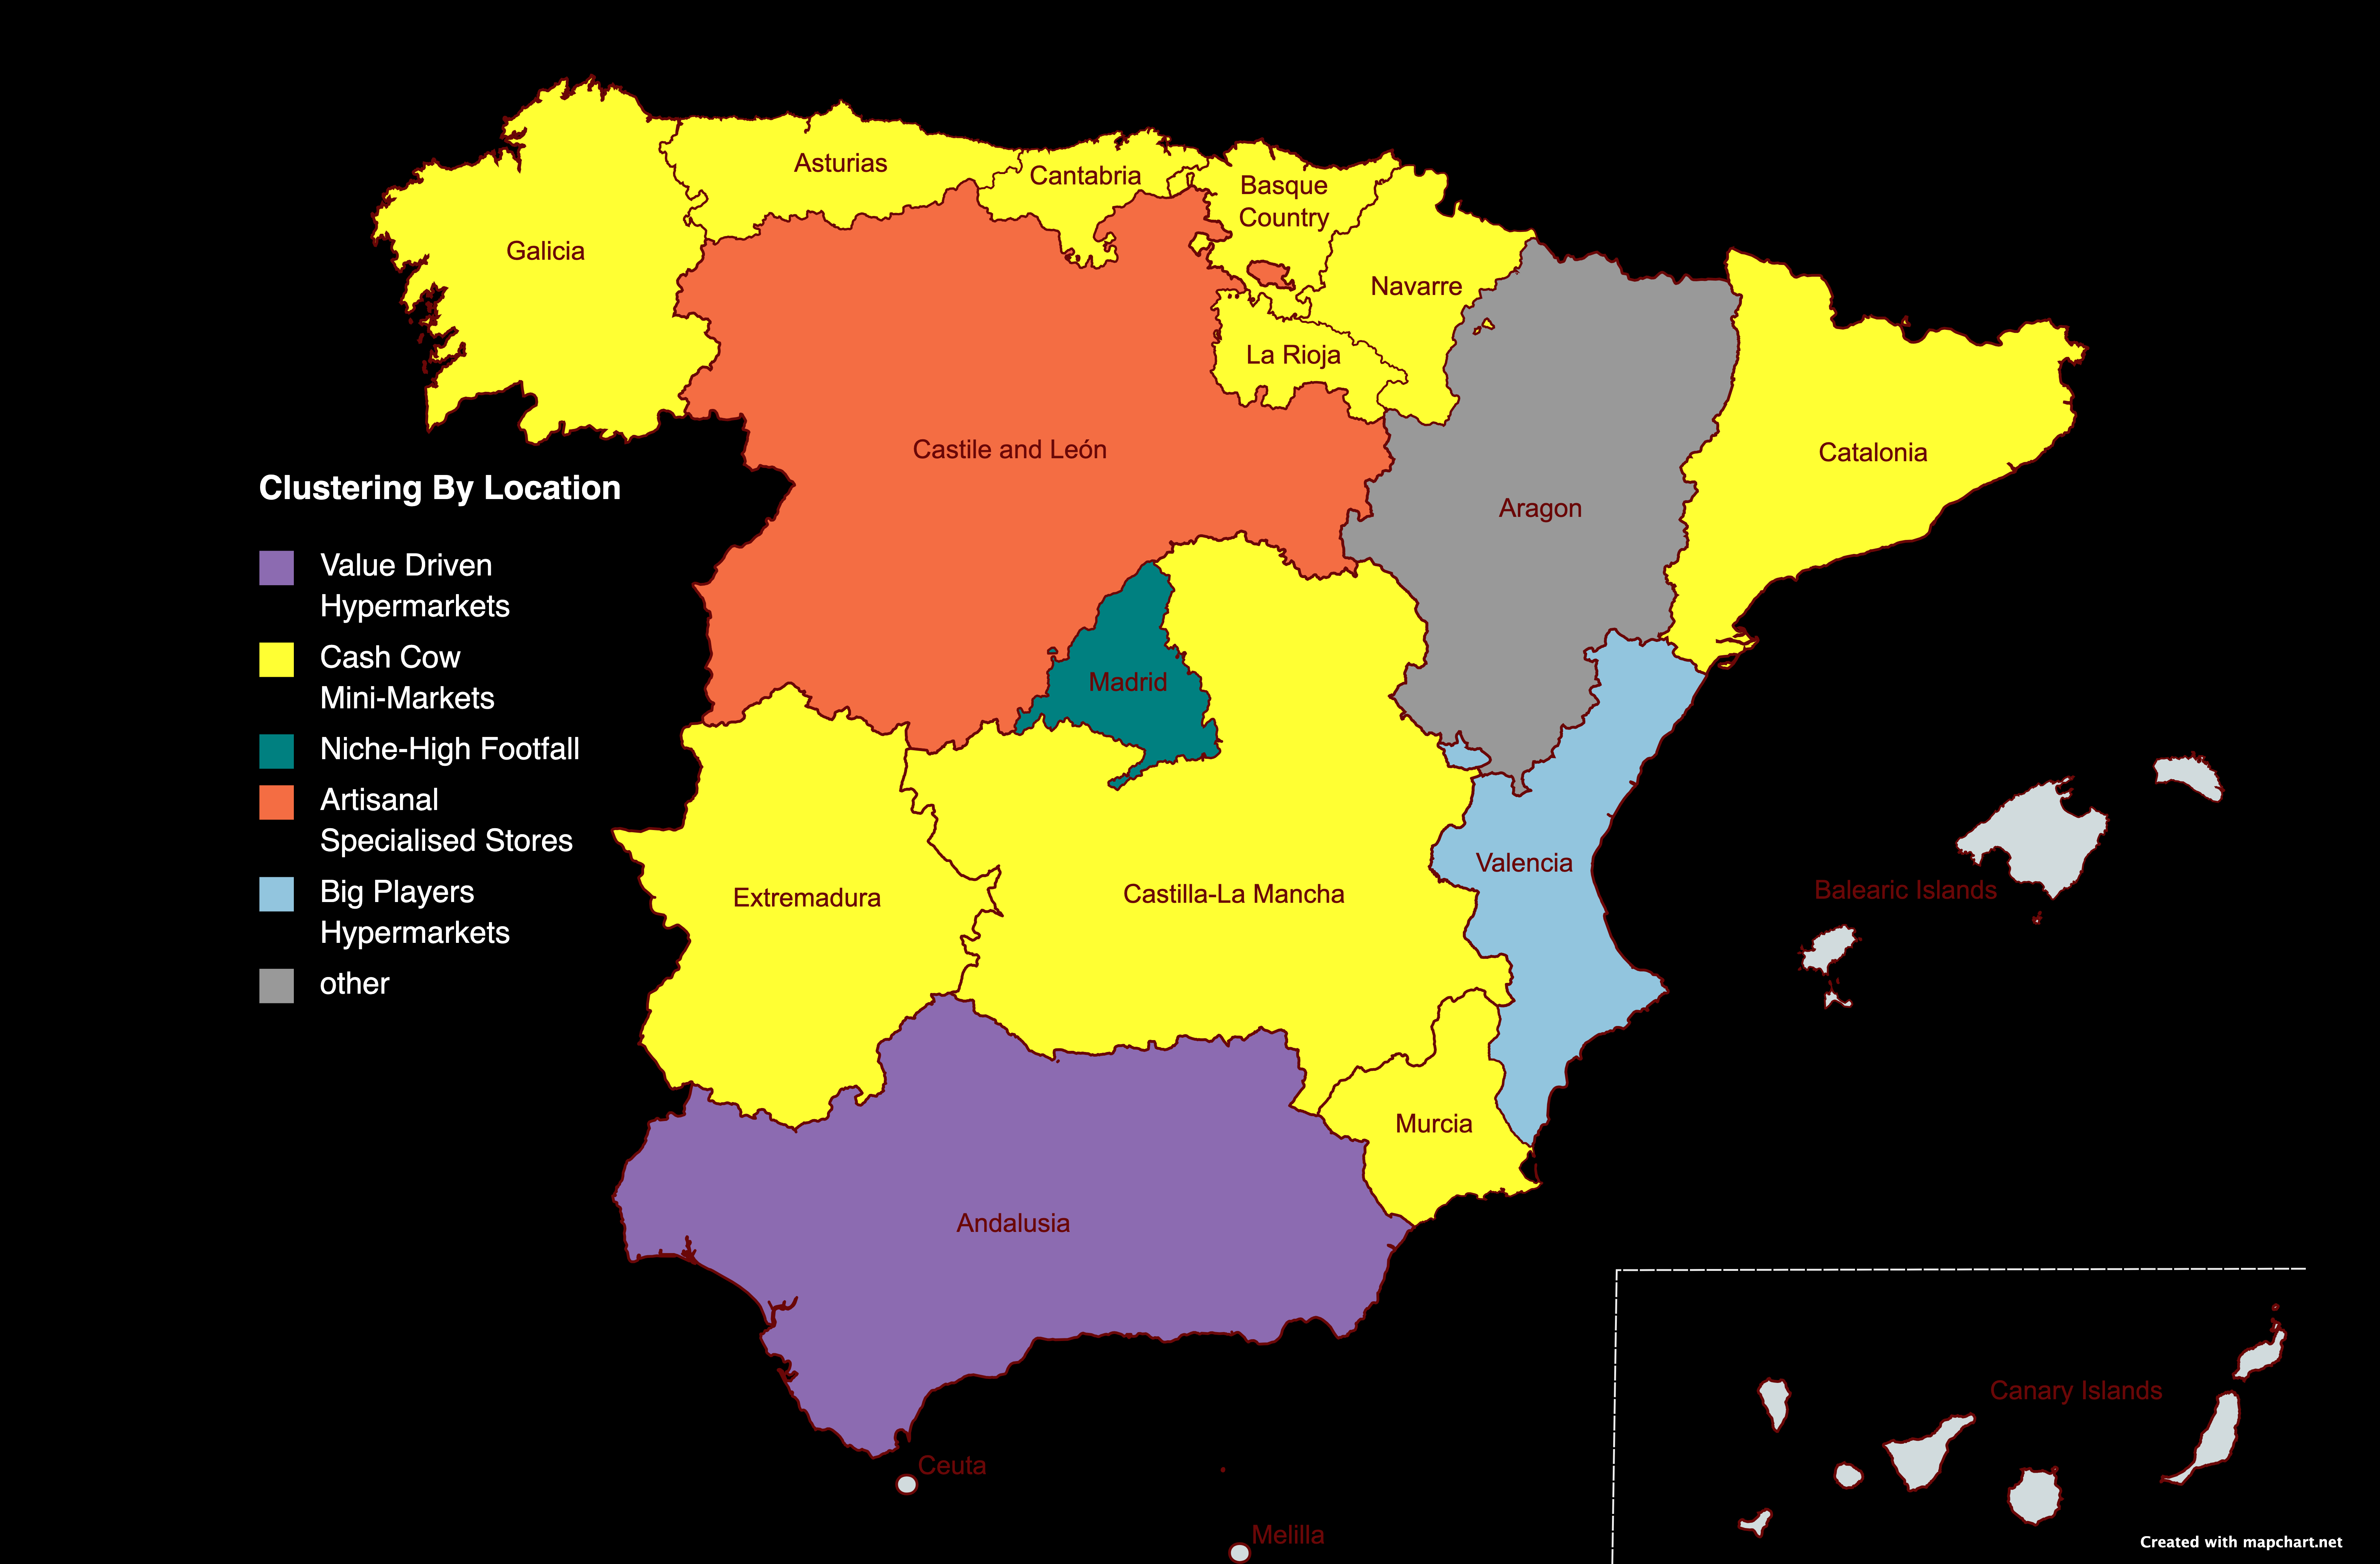

# <span style="color: purple">**5. Conculsion and Recommendation**</span> <a class="anchor" id="section_5"></a>

**Clusters Profiles:**

Our proposed segmentation splits the beers category stores into 5 main store segments where we are arranging them based on square meter from largest to smallest.


1.   2 types of hypermarkets
2.   3 types of supermarkets


**Cluster 0 key characteristics are: Niche Super Markets with High Footfall**

Population is high yet the liters consumption is the lowest among other clusters. The pricing in this cluster is relatively high hence the sales in value is high. And, it represents a total of 13.4% of the total stores. Its surface square meter is average.
Location representation is mainly in Autonomous community of Madrid
BEER segments: Import Preimum & National lead followed by Extra and flavoured .

**Cluster 1 key characteristics are Value Driven Hypermarkets**

Large sized stores in terms of surface with average population & liters consumption and located in high temperature areas. The pricing in this cluster is the lowest. And, it represents a total of 14% of the total stores.
Location representation : Autonomous community of Andalucia
BEER Segments  : National  followed by Import premium


**Cluster 2 key characteristics are Artisanal Specialized Stores**

Small sized stores in terms of surface with high liters consumption and located in low temperature areas. The pricing in this cluster is the highest resulting in relatively higher sales in value. And, it represents only 1% of the total stores.
Location : Castilla Y Leon
Beer Segments : National followed by Flavoured and Import Premium


**Cluster 3 key characteristics are The Cash Cow Mini-Markets**


This cluster is the most spread across the country with 55% of total stores. It is the typical average sized supermarket with average sales and relatively high price sensitivity. Overall, the sales in value in this cluster is the lowest.
Location distribution : Asturias, Baleares, cantabria,Castilla- La Mancha, cataluna,Extremadura,Galicia,La Riojia,Murcia, Navarram Pais Vasco

Beer Segments : This cluster shows strong preference to nationale (2X)  versus Import premium , Flavoured ,Extra

**Cluster 4 key characteristics are The Big Players Hypermarkets**

They are the few largest stores in terms of surface square meters. They offer value yet they have the full range. Their sales in value is relatively high and they are located in the high populated areas (the main cities). They represent >1% of the total stores.
Location:  Comunidad Valenciana
Beer segments: Nationale preference almost (2X) with flavoured , Extra and import premium



**Recommendation**
*  Ensure having a diversified distribution strategy across the stores segments especially for National segment
*  Stores square meter is positively correlated to sales hence focusing on large stores would yield higher sales
*  For highest penetration focus on Cash Cow Mini Markets as they are the most spread type of stores
*  Pricing and promotions should match the segment's profile
*  For the niche beer segments ensure distributing in; Niche Super Markets & Artisanal Specialized Stores
*  Cash Cow Mini Markets are the most spread type of stores yet geographically we believe they need to be subdivided to ensure effective distribution strategy




